## Detecting Rotten and Fresh Fruit Using AI ##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

! unzip -q '/content/drive/My Drive/Colab Notebooks/fooddata.zip' -d '/content'

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Found 21044 images belonging to 14 classes.
Found 6738 images belonging to 14 classes.
1/1 [==============================] - 0s 137ms/step


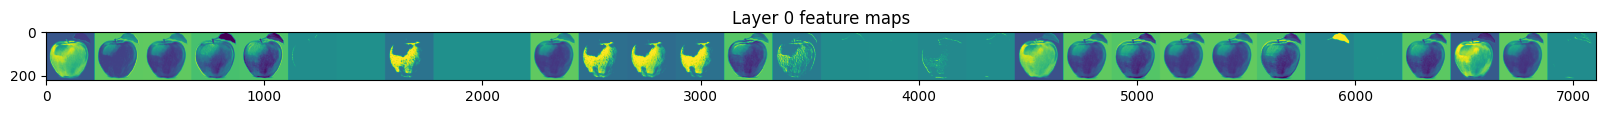

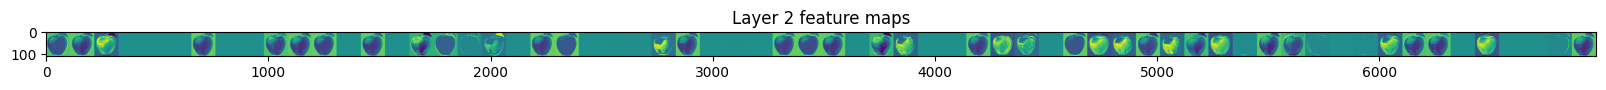

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

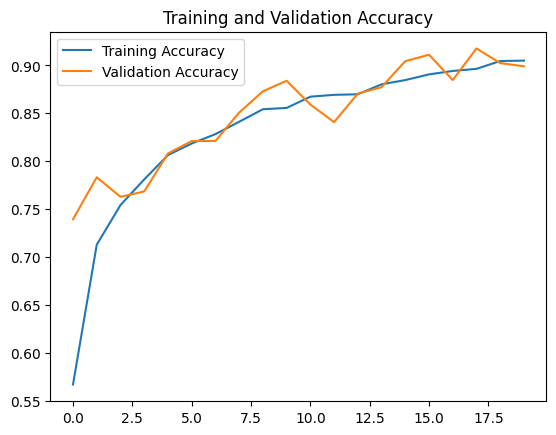

In [ ]:

def load_data_base(directory, image_size=(224, 224), batch_size=64, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(
            rescale=1./255
        )

    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=augment
    )
    return generator

def build_model():

    initial_learning_rate = 0.001
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(14, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model


def train_and_evaluate(model, train_generator, test_generator, epochs=40):
    model.summary()
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator
    )

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    return history


def visualize_feature_maps(model, image_path, layer_indices):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    outputs = [model.layers[i].output for i in layer_indices]
    model = keras.models.Model(inputs=model.input, outputs=outputs)
    feature_maps = model.predict(img_array)

    for fmap, layer_idx in zip(feature_maps, layer_indices):
        num_features = fmap.shape[-1]
        size = fmap.shape[1]
        display_grid = np.zeros((size, size * num_features))

        for i in range(num_features):
            x = fmap[0, :, :, i]
            x -= x.mean()
            x /= x.std() + 1e-6
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x

        scale = 20. / num_features
        plt.figure(figsize=(scale * num_features, scale))
        plt.title(f'Layer {layer_idx} feature maps')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()


train_generator_base = load_data_base('/content/dataset/Train', image_size=(224, 224), batch_size=64, augment=True)
test_generator_base = load_data_base('/content/dataset/Test', image_size=(224, 224), batch_size=64, augment=False)

base_model = build_model()
visualize_feature_maps(base_model, '/content/dataset/Train/freshapples/Screen Shot 2018-06-08 at 4.59.36 PM.png', [0, 2])
history_original = train_and_evaluate(base_model, train_generator_base, test_generator_base, epochs=20)


17225924/17225924 [==============================] - 0s 0us/step
Found 21044 images belonging to 14 classes.
Found 6738 images belonging to 14 classes.


Epoch 1/5
329/329 [==============================] - 353s 1s/step - loss: 0.3366 - accuracy: 0.8937 - precision_1: 0.9431 - recall_1: 0.8595 - val_loss: 0.1965 - val_accuracy: 0.9325 - val_precision_1: 0.9517 - val_recall_1: 0.9130
Epoch 2/5
329/329 [==============================] - 349s 1s/step - loss: 0.1402 - accuracy: 0.9556 - precision_1: 0.9644 - recall_1: 0.9445 - val_loss: 0.1742 - val_accuracy: 0.9366 - val_precision_1: 0.9518 - val_recall_1: 0.9242
Epoch 3/5
329/329 [==============================] - 350s 1s/step - loss: 0.1147 - accuracy: 0.9644 - precision_1: 0.9714 - recall_1: 0.9569 - val_loss: 0.1436 - val_accuracy: 0.9504 - val_precision_1: 0.9576 - val_recall_1: 0.9390
Epoch 4/5
329/329 [==============================] - 350s 1s/step - loss: 0.0996 - accuracy: 0.9686 - precision_1: 0.9747 - recall_1: 0.9621 - val_loss: 0.1325 - val_accuracy: 0.9513 - val_precision_1: 0.9635 - val_recall_1: 0.9436
Epoch 5/5
329/329 [==============================] - 349s 1s/step - loss

Epoch 1/5
329/329 [==============================] - 504s 2s/step - loss: 0.1564 - accuracy: 0.9495 - precision_2: 0.9547 - recall_2: 0.9449 - val_loss: 0.1074 - val_accuracy: 0.9632 - val_precision_2: 0.9669 - val_recall_2: 0.9581
Epoch 2/5
329/329 [==============================] - 502s 2s/step - loss: 0.0613 - accuracy: 0.9787 - precision_2: 0.9802 - recall_2: 0.9773 - val_loss: 0.0735 - val_accuracy: 0.9768 - val_precision_2: 0.9790 - val_recall_2: 0.9751
Epoch 3/5
329/329 [==============================] - 505s 2s/step - loss: 0.0362 - accuracy: 0.9877 - precision_2: 0.9886 - recall_2: 0.9868 - val_loss: 0.0762 - val_accuracy: 0.9731 - val_precision_2: 0.9753 - val_recall_2: 0.9711
Epoch 4/5
329/329 [==============================] - 507s 2s/step - loss: 0.0292 - accuracy: 0.9894 - precision_2: 0.9902 - recall_2: 0.9889 - val_loss: 0.0294 - val_accuracy: 0.9901 - val_precision_2: 0.9912 - val_recall_2: 0.9895
Epoch 5/5
329/329 [==============================] - 506s 2s/step - loss

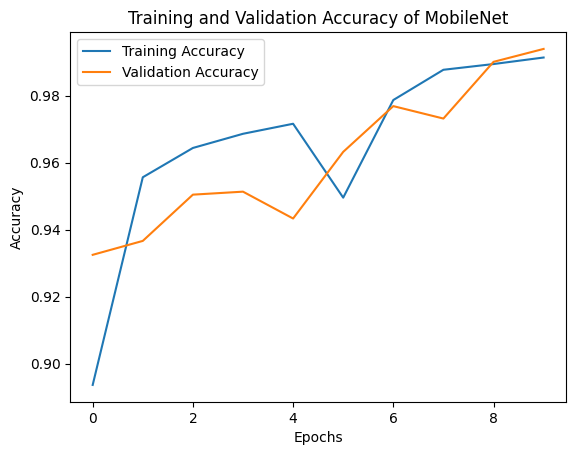

In [ ]:
def load_data_mobilenet(directory, image_size=(224, 224), batch_size=64, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            preprocessing_function=mobilenet_preprocess_input,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(
            preprocessing_function=mobilenet_preprocess_input
        )

    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=augment
    )
    return generator

base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model_mobilenet.output)
predictions = Dense(14, activation='softmax')(x)
mobilenet_model = keras.models.Model(inputs=base_model_mobilenet.input, outputs=predictions)

for layer in base_model_mobilenet.layers:
    layer.trainable = False

train_generator_mobilenet = load_data_mobilenet('/content/dataset/Train', image_size=(224, 224), batch_size=64, augment=True)
test_generator_mobilenet = load_data_mobilenet('/content/dataset/Test', image_size=(224, 224), batch_size=64, augment=False)

mobilenet_model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

history_mobilenet_1 = mobilenet_model.fit(train_generator_mobilenet, validation_data=test_generator_mobilenet, epochs=5)

for layer in base_model_mobilenet.layers:
    layer.trainable = True

mobilenet_model.compile(optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

history_mobilenet_2 = mobilenet_model.fit(train_generator_mobilenet, validation_data=test_generator_mobilenet, epochs=5)

plt.plot(history_mobilenet_1.history['accuracy'] + history_mobilenet_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet_1.history['val_accuracy'] + history_mobilenet_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Found 21044 images belonging to 14 classes.
Found 6738 images belonging to 14 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)   

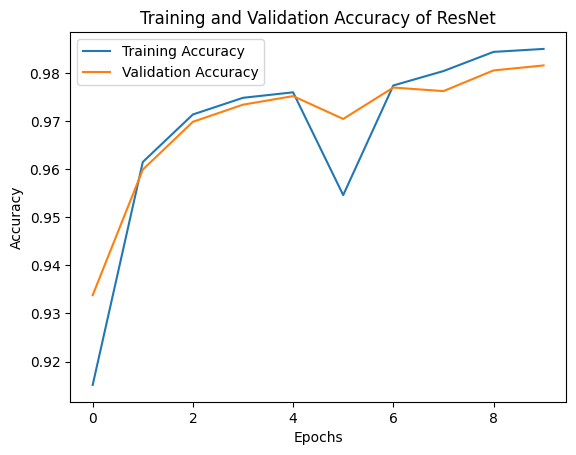

In [ ]:
keras.backend.clear_session()

def load_data_resnet(directory, image_size=(224, 224), batch_size=64, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            preprocessing_function=resnet_preprocess_input,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(
            preprocessing_function=resnet_preprocess_input
        )

    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=augment
    )
    return generator


train_generator_resnet = load_data_resnet('/content/dataset/Train', image_size=(224, 224), batch_size=64, augment=True)
test_generator_resnet = load_data_resnet('/content/dataset/Test', image_size=(224, 224), batch_size=64, augment=False)


model_inbuilt = keras.applications.ResNet50(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(model_inbuilt.output)
output = keras.layers.Dense(14, activation="softmax")(avg)
resnet_model = keras.models.Model(inputs=model_inbuilt.input, outputs=output)
resnet_model.summary()

for layer in model_inbuilt.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
resnet_model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=['accuracy', Precision(), Recall()])
history_resnet_1 = resnet_model.fit(train_generator_resnet,
                    validation_data=test_generator_resnet,
                    epochs=5)

for layer in model_inbuilt.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9,
                                 nesterov=True)
resnet_model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=['accuracy', Precision(), Recall()])
history_resnet_2 = resnet_model.fit(train_generator_resnet,
                    validation_data=test_generator_resnet,
                    epochs=5)

plt.plot(history_resnet_1.history['accuracy'] + history_resnet_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_1.history['val_accuracy'] + history_resnet_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of ResNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

106/106 [==============================] - 36s 333ms/step


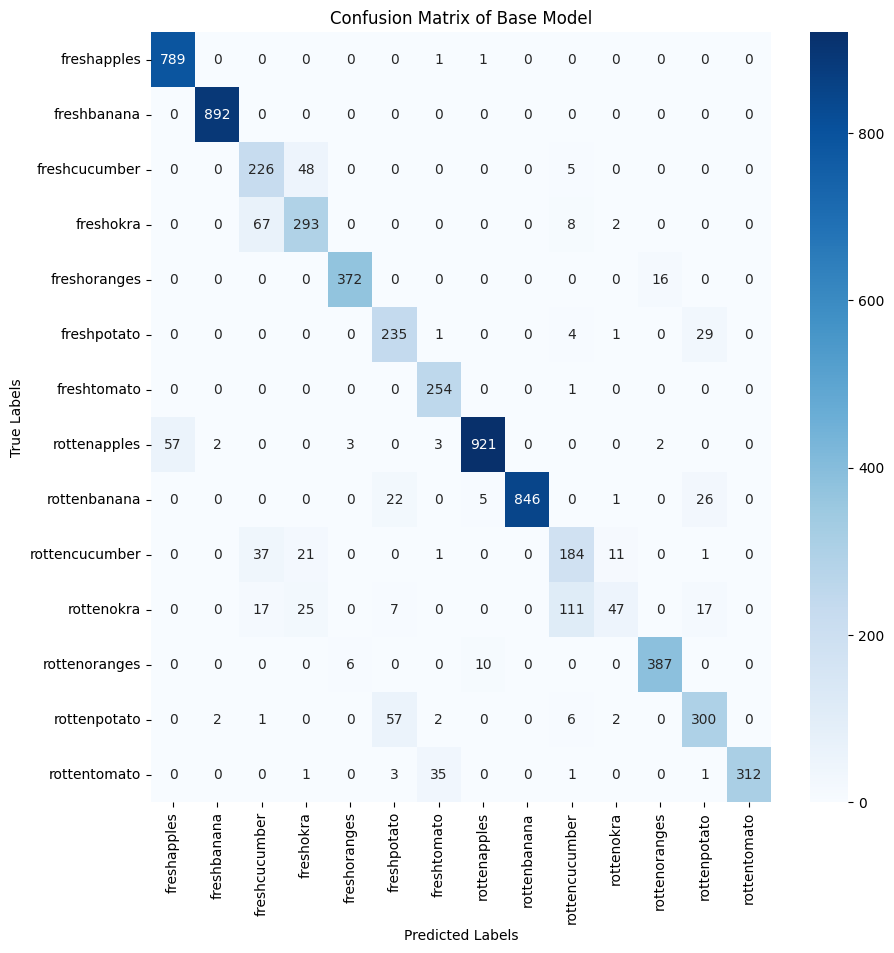

106/106 [==============================] - 43s 404ms/step


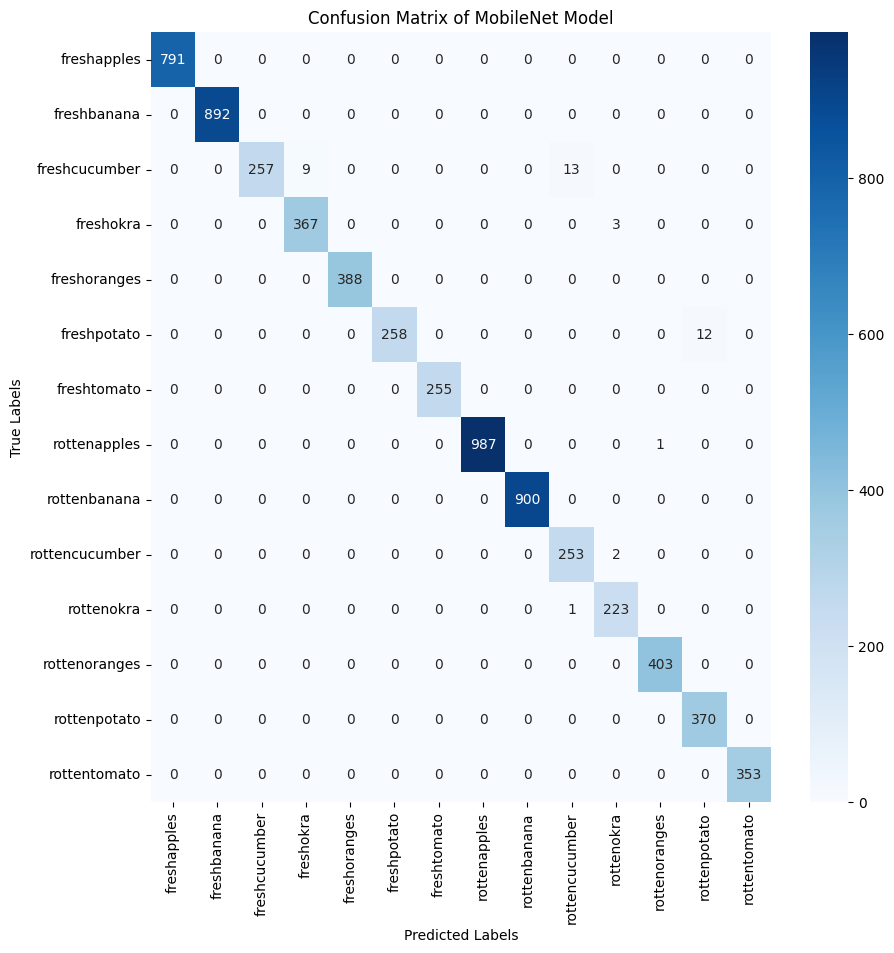

106/106 [==============================] - 121s 1s/step


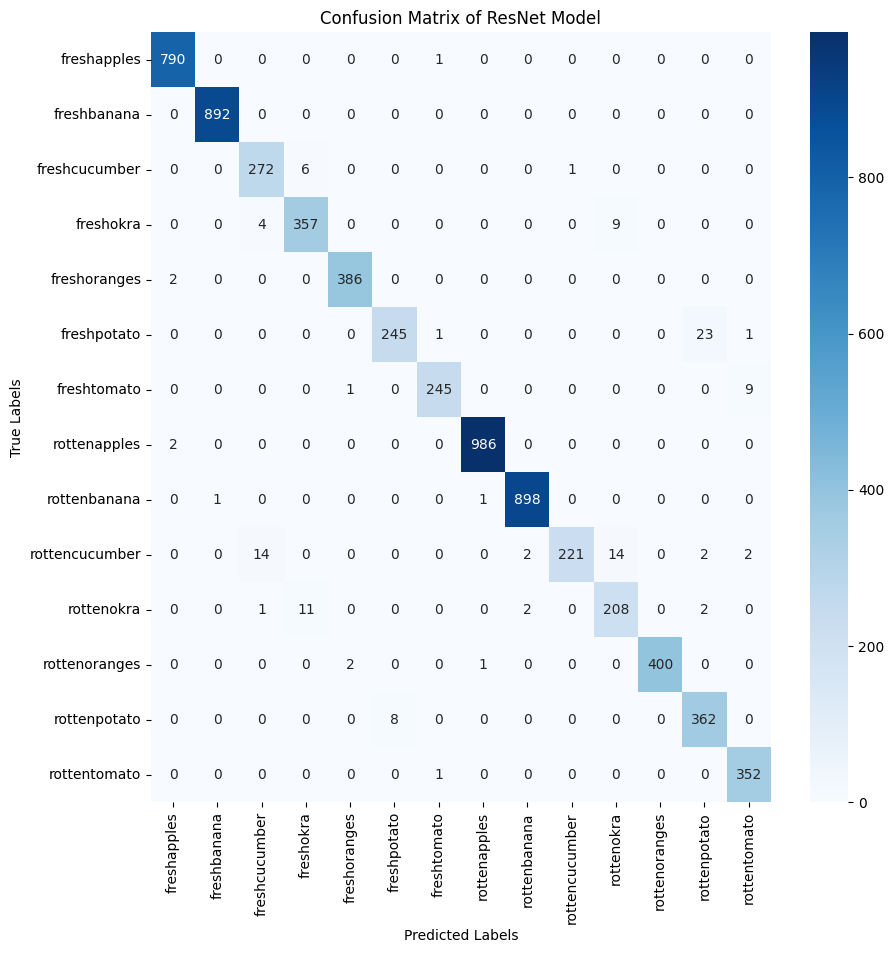

In [ ]:
# Base model
test_generator_base.reset()
predictions = base_model.predict(test_generator_base, steps=len(test_generator_base), verbose=1)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator_base.classes

class_labels = list(test_generator_base.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix of Base Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

#Mobilenet Model
test_generator_mobilenet.reset()
predictions = mobilenet_model.predict(test_generator_mobilenet, steps=len(test_generator_mobilenet), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator_mobilenet.classes

class_labels = list(test_generator_mobilenet.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix of MobileNet Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


#Resnet Model
test_generator_resnet.reset()
predictions = resnet_model.predict(test_generator_resnet, steps=len(test_generator_resnet), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator_resnet.classes

class_labels = list(test_generator_resnet.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix of ResNet Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()